# This is how I'll want to use the inversion package on simple problems

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
from fatiando import utils
import cPickle as pickle
from inversion import LinearMisfit

In [46]:
x = np.linspace(-100, 100, 100)
coefs = d, c, b, a = 0.5, 0, 1, 1000
y = a*x**3 + b*x**2 + c*x + d
yo = utils.contaminate(y, 0.1, percent=True, seed=0)

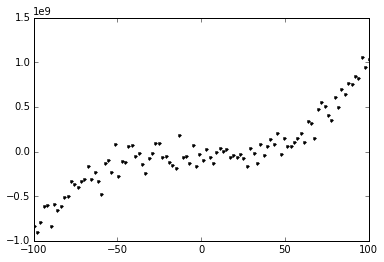

In [47]:
plt.plot(x, yo, '.k')

In [48]:
class Regression(LinearMisfit):
    def __init__(self, degree):
        super().__init__(nparams=(degree + 1))
        self.degree = degree
        
    def predict(self, x, p=None):
        if p is None:
            p = self.p_
        return sum(p[i]*x**i for i in range(self.nparams))
        
    def jacobian(self, x, p):
        A = np.empty((x.size, self.nparams))
        for i in range(self.nparams):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, weights=None):
        self.optimize(data=y, x=x, weights=weights)
        return self
    
    def fmt_estimate(self, p):
        eq = ' + '.join(['{:g}x^{}'.format(p[i], i) for i in range(self.nparams)])
        return eq

In [49]:
reg = Regression(3)
reg.fit(x, yo).p_

array([ -4.40391451e+07,  -1.96728157e+05,   1.29511250e+04,
         1.00785296e+03])

In [50]:
reg.fmt_estimate(coefs[::-1])

'1000x^0 + 1x^1 + 0x^2 + 0.5x^3'

In [51]:
reg.estimate_
# Should print the equation

'-4.40391e+07x^0 + -196728x^1 + 12951.1x^2 + 1007.85x^3'

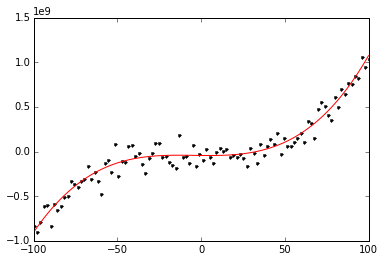

In [52]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

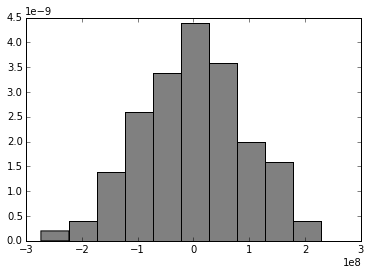

In [53]:
_ = plt.hist(yo - reg.predict(x), 10, normed=True, color='grey')

In [54]:
reg = pickle.loads(pickle.dumps(reg))

In [55]:
A1 = reg.jacobian(reg.p_, x)

In [56]:
reg.config(method='newton', intial=[1, 1, 1]).fit(x, yo).estimate_

AttributeError: 'Regression' object has no attribute 'config'

In [57]:
reg.jacobian(reg.p_, x) is A1

False

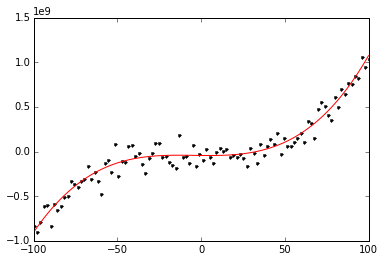

In [58]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Using cross-validation

In [65]:
whole = np.random.permutation(x.size)
divide = int(0.6*x.size)
train, test = whole[:divide], whole[divide:]

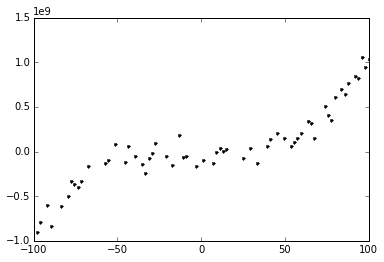

In [66]:
plt.plot(x[train], yo[train], '.k')

In [67]:
degrees = list(range(1, 20))
scores = [Regression(i).fit(x[train], yo[train]).score(x[test], yo[test])
          for i in degrees]
best = degrees[np.argmin(scores)]
best

3

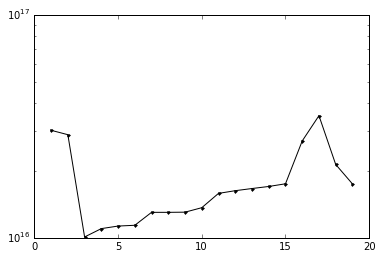

In [68]:
plt.plot(degrees, scores, '.-k')
plt.yscale('log')

In [69]:
reg = Regression(best).fit(x, yo)
reg.estimate_

'-4.40391e+07x^0 + -196728x^1 + 12951.1x^2 + 1007.85x^3'

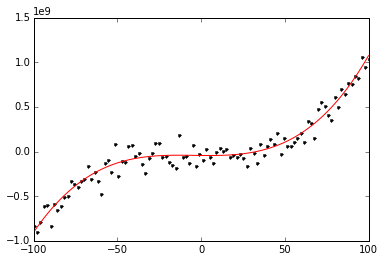

In [70]:
plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# Re-weighted

In [71]:
yo2 = np.copy(yo)
yo2[[30, 40, 60, 70]] += 1e9

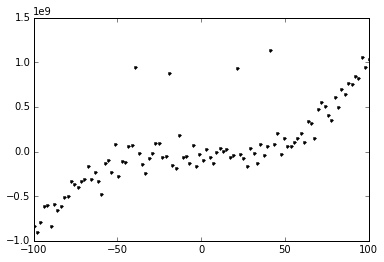

In [72]:
plt.plot(x, yo2, '.k')

In [73]:
reg = Regression(3).fit(x, yo2)
reg.estimate_

'3.09549e+07x^0 + -153651x^1 + 2660.81x^2 + 1002.76x^3'

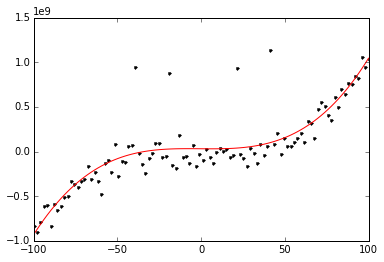

In [74]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg.predict(x), '-r')

In [75]:
reg2 = Regression(3).fit(x, yo2)
r = np.abs(yo2 - reg2.predict(x))
reg2.fit(x, yo2, weights=1/r).estimate_

'1.69896e+07x^0 + -31466.6x^1 + 4256.59x^2 + 983.108x^3'

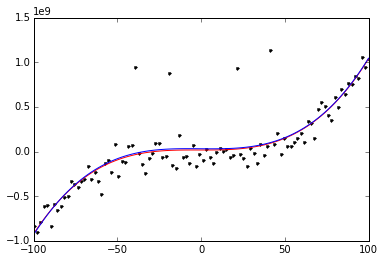

In [76]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg2.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

In [77]:
reg3 = Regression(3).fit_reweighted(x, yo2, iterations=10)
reg3.estimate_

'-2.85017e+07x^0 + 32513x^1 + 9948.49x^2 + 963.77x^3'

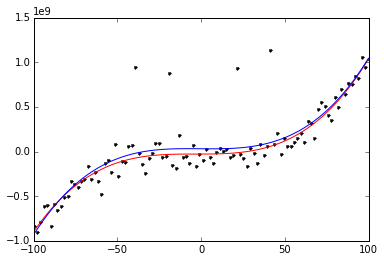

In [78]:
plt.plot(x, yo2, '.k')
plt.plot(x, reg3.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

# Multiple data sets

In [ ]:
x2 = np.linspace(150, 200, 200)
y2 = 0.05*(x2 - 50)**3 + 1000
yo2 = utils.contaminate(y2, 0.1, percent=True)

In [ ]:
plt.plot(x, yo, '.k')
plt.plot(x2, yo2, '.b')

In [ ]:
(Regression(3) + 1e-10*Regression(1)).fit(x, yo, x2, yo2).estimate_

In [ ]:
(1e-10*Regression(3) + Regression(1)).fit(x, yo, x2, yo2).estimate_